In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Lines below allow to import modules of this project
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import random
import string
import itertools

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set()

# DreamPlace Algorithms

This notebook tries to reproduce some of the functionality of
the DreamPlace paper

There there are three important algorithms:

* Global Placement (GP)
* Legalization (LG)
* Detailed Placement (DP)

OBS: Implementation below only talk about x direction. The same can be achieve for the y direction.

### Notations:

* V : set of cells
* P : set of pins $t$ or $i$
* E : set of nets $e$
* B : set of bins


* $x_e^+$ : $max_{i \in e} x_i, \forall e \in E$
* $x_e^-$ : $min_{i \in e} x_i, \forall e \in E$


* $a_i^+$ : $e^\frac{x_i-x_e^+}{\gamma}, \forall i\in e, e \in E$
* $a_i^-$ : $e^\frac{x_i-x_e^-}{\gamma}, \forall i\in e, e \in E$


* $b_e^+$ : $\sum_{i \in e}  a^+, \forall e \in E$
* $b_e^-$ : $\sum_{i \in e}  a^-, \forall e \in E$


* $c_e^+$ : $\sum_{i \in e} x_i a^+, \forall e \in E$
* $c_e^-$ : $\sum_{i \in e} x_i a^-, \forall e \in E$


* $\vec x^+$ : $\{x_e^+\}, \forall e \in E$
* $\vec x^-$ : $\{x_e^-\}, \forall e \in E$


* $\vec a^+$ : $\{a_i^+\}, \forall i \in P$
* $\vec a^-$ : $\{a_i^-\}, \forall i \in P$


* $\vec b^+$ : $\{b_e^+\}, \forall e \in E$
* $\vec b^-$ : $\{b_e^-\}, \forall e \in E$


* $\vec c^+$ : $\{c_e^+\}, \forall e \in E$
* $\vec c^-$ : $\{c_e^-\}, \forall e \in E$

In [12]:
def x_e_p (net_id, pins, locations):
    return np.max(np.multiply(pins,locations))

def x_e_m (net_id, pins, locations):
    return np.min(np.multiply(pins,locations))

def a_i_p (net_id, pins):
    return np.max(pins.x)

def a_i_m (net_id, pins):
    return np.min(pins.x)

### Process

With the variables below, the GP problem becomes:

* $WL$ - Function that calculates Wirelength cost function
  * Takes any net $e$ and returns wirelenght
* $D$ -  Regularization function (density penalty to spread out cells)

$min(\sum_{e\in E} WL(e;\vec{x},\vec{y} +\alpha D(\vec{x},\vec{y})$

In [5]:
# TODO

Actual used formula: Weighted-average wirelength

$WA_e=\frac{\sum_{i \in e} x_i e^{\frac{x_i}{\gamma}}}{\sum_{i \in e} e^{\frac{x_i}{\gamma}}}$
$-\frac{\sum_{i \in e} x_i e^{\frac{-x_i}{\gamma}}}{\sum_{i \in e} e^{\frac{-x_i}{\gamma}}}$


With:

* $\gamma$ - parameter to control the smoothness and accuracy of the approximation to half-permieter wirelenght (HPWL)

Its derivative is given by:

$\frac{\delta WL_e}{\delta x_i} =$
$\frac{(1+\frac{x_i}{\gamma})b_e^+ -\frac{1}{\gamma}c_e^+}{(b_e^+)^2}\cdot a_i^+$
$-\frac{(1-\frac{x_i}{\gamma})b_e^- +\frac{1}{\gamma}c_e^-}{(b_e^-)^2}\cdot a_i^-$

In [6]:
# TODO

### Steps:

Initial placement: Standard cells are placed in the center of the layout with a small Gaussian noise.
The scales of noise are set to 0.1% of the width and height of the placement region in the experiment.


GP: GlobalPlacement Iterations: Loop that involves the computation of wirelength and density gradient, optimization engines, and cell location updating.

LG: Legalization is performed to remove remaining overlaps and align cells to placements sites

DP: Detailed placement to refine the placement solutions using NTUplace3.

In [7]:
# TODO

# Data generation

In [4]:
def get_adjacency_matrix(net_matrix):
    """Returns adjacency matrix based on nets matrix"""
    N_NETS=net_matrix.shape[0]
    N_COMPONENTS=net_matrix.shape[1]
    
    adjacency_matrix=np.zeros(shape=(N_COMPONENTS,N_COMPONENTS))
    for net_idx in range (N_NETS):
        to_connect=[]
        for pin_idx in range (N_COMPONENTS):
            if net_matrix[net_idx,pin_idx]==1 :
                to_connect.append(pin_idx)

        index_list = [index for index in itertools.product(to_connect, to_connect)]

        for index in index_list:            
            adjacency_matrix[index]=1
    
    adjacency_matrix[np.identity(N_COMPONENTS, dtype=bool)]=0 # componets do not connect to themselves
    return adjacency_matrix

In [4]:
from datagem.datagem import generate_random_name,generate_random_position,generate_random_sizes
from board.utils import get_adjacency_matrix

In [5]:
print(generate_random_name())
print(generate_random_position())
print(generate_random_sizes())
print(generate_random_sizes(mode='triangular'))

YGV_81
(190.0, 137.0)
(4.0, 6.0)
(4.0, 5.0)


### Generate Important Arrays

In [20]:
# Here we consider that we have a set of V cells first allocated at random position on a 
# 200mm X 200mm grid
grid_dim = (200,200)
N_COMPONENTS=10
N_NETS=np.int(np.floor(N_COMPONENTS*.4))
connection_density=.2

# Generate Components names
components_set = {generate_random_name() for x in range(N_COMPONENTS)}

# Generate nets_matrix
net_matrix=np.random.choice([0, 1], size=(N_NETS,N_COMPONENTS), p=[1-connection_density, connection_density])

# Compute Adjacency Matrix from net matrix
adjacency_matrix=get_adjacency_matrix(net_matrix)

# Generate Componenets X,Y valuesmode
position_array = np.array([generate_random_position(mode='gaussian',sigma=25) for _ in range(N_COMPONENTS)])
#position_array = np.array([generate_random_position(mode='uniform') for _ in range(N_COMPONENTS)])

# Generate Compinents Sizes W and H (size_x,size_y)
dimension_array = np.array([generate_random_sizes(5,30,mode='triangular') for _ in range(N_COMPONENTS)])

In [21]:
print('\ncomponents_set (number_of_components)')
print(components_set)

print('\nnet_matrix (number_of_nets,number_of_components)')
print(net_matrix)

print('\nadjacency_matrix (number_of_components,number_of_components)')
print(adjacency_matrix)

print('\nposition_array (number_of_components,2)')
print(position_array)

print('\ndimension_array (number_of_components,2)')
print(dimension_array)


components_set (number_of_components)
{'QMR_37', 'XNH_63', 'DNX_88', 'KCC_19', 'BOR_97', 'EIS_55', 'CJQ_70', 'GOT_07', 'OWB_23', 'YFI_69'}

net_matrix (number_of_nets,number_of_components)
[[1 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 0 1 0]]

adjacency_matrix (number_of_components,number_of_components)
[[0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]

position_array (number_of_components,2)
[[ 85.  43.]
 [ 80.  63.]
 [121. 163.]
 [118. 122.]
 [ 90.  85.]
 [109.  84.]
 [134. 127.]
 [ 90. 125.]
 [110. 148.]
 [ 68.  52.]]

dimension_array (number_of_components,2)
[[12. 17.]
 [ 7. 14.]
 [14. 15.]
 [10. 16.]
 [ 9. 10.]
 [17. 13.]
 [12. 13.]
 [16. 11.]
 [17. 13.]
 [16. 11.]]

In [22]:
print('\npin_set (number_of_pins)')
print(components_set)

print('\nnet_matrix (number_of_nets,number_of_pins)')
print(net_matrix)

print('\nadjacency_matrix (number_of_pins,number_of_pins)')
print(adjacency_matrix)

print('\nposition_array (number_of_components,2)')
print(position_array)

print('\ndimension_array (number_of_components,2)')
print(dimension_array)


pin_set (number_of_pins)
{'QMR_37', 'XNH_63', 'DNX_88', 'KCC_19', 'BOR_97', 'EIS_55', 'CJQ_70', 'GOT_07', 'OWB_23', 'YFI_69'}

net_matrix (number_of_nets,number_of_pins)
[[1 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 0 1 0]]

adjacency_matrix (number_of_pins,number_of_pins)
[[0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]

position_array (number_of_components,2)
[[ 85.  43.]
 [ 80.  63.]
 [121. 163.]
 [118. 122.]
 [ 90.  85.]
 [109.  84.]
 [134. 127.]
 [ 90. 125.]
 [110. 148.]
 [ 68.  52.]]

dimension_array (number_of_components,2)
[[12. 17.]
 [ 7. 14.]
 [14. 15.]
 [10. 16.]
 [ 9. 10.]
 [17. 13.]
 [12. 13.]
 [16. 11.]
 [17. 13.]
 [16. 11.]]


### Plotting initial data

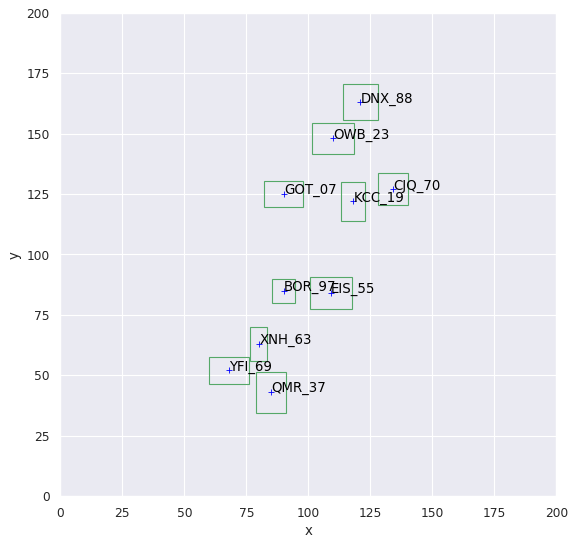

In [23]:
# Create dataframe
df = pd.DataFrame({
    'x': position_array[:,0],
    'y': position_array[:,1],
    'w': dimension_array[:,0],
    'h': dimension_array[:,1],
    'group': list(components_set)
})
 
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
p1 = sns.scatterplot(data=df, x="x", y="y", marker="+", color="blue")


plt.xlim(0, grid_dim[0])
plt.ylim(0, grid_dim[1])

# add annotations one by one with a loop
for line in range(0,df.shape[0]):
    p1.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', color='black')


ax = plt.gca()

for line in range(0,df.shape[0]):
    ax.add_patch(Rectangle((df.x[line]-df.w[line]/2, df.y[line]-df.h[line]/2), df.w[line], df.h[line], fill=None, alpha=1,color='g'))
plt.show()